# Women's Clothing E-Commerce with Natural Language Processing 
_By Nicolas Brooks, Summer 2017_

***

**Programming Language:** Python 3.5 in the Jupyter Notebook Environment

**Textbook Resources Used:** <br>
- Swamynathan, Manohar. Mastering Machine Learning with Python in Six Steps: a Practical
- Implementation Guide to Predictive Data Analytics Using Python. Apress, 2017.
- Bird, Steven. Natural Language Processing with Python. O&#39;Reilly Media, 2016.

**Code Navigation:** <br>
In the code, text after hastags (#) are supportive explanations, not executed as code.
Indented line signifies code is part of larger function or loop. Not standalone. Furthermore,
functions are used in order to facilitate the simplicity and exploratory process of the code.
Code: Packages Used

# Tables of Content:

1. [Introduction](#Introduction)
2. [Pre-Processing](#Pre-Processing)
3. [Helper/Utility Functions](#Helper/Utility Functions)
4. [Exploratory Data Analysis](#Exploratory Data Analysis)
5. [Sentiment Analysis](#Sentiment Analysis)
6. [Word Distribution and Word Cloud](#Word Distribution and Word Cloud)
7. [Supervised Learning](#Supervised Learning)
8. [Word2Vec](#Word2Vec)

# **1. Introduction:** <a id="Introduction"></a> <br>
This notebook is concerned with using the Python programming language and Natural Language Processing technology to explore trends in the customer reviews from an anonymized women’s clothing retail store, and extract actionable plans to improve its online e-commerce. The data is a collection of 23,486 rows with 17 featured variables. Each row includes a written comment as well as additional customer information. This analysis will focus on using Natural Language techniques to find broad trends in the written thoughts of the customers. The total number of unique words in the dataset is 9810. In this analysis, the data will be introduced using exploratory data analysis, and will be further analyzed by employing:

- **Frequency distribution**
- **Word Clouds**
- **Sentiment Analysis**
- **Naive Bayes**
- **Word2Vec**

In [1]:
# General
import numpy as np
import pandas as pd
import nltk
import random
import os
from os import path
from PIL import Image

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
# Set Plot Theme
sns.set_palette([
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",
])
# Alternate # plt.style.use('fivethirtyeight')

# Pre-Processing
import string
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
from nltk.stem import PorterStemmer

# Modeling
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk.util import ngrams
from collections import Counter
from gensim.models import word2vec

# Warnings
import warnings
warnings.filterwarnings('ignore')

/Users/nicapotato/anaconda/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


### **Code Explanation:** <br>
These packages are seperated in four categories: *General, Visualization, Pre-Processing, and Modeling*.

The General category includes the basic data manipulation tools for scientific computation (numpy), dataframes (pandas), Natural Language Processing (NLTK), path directory manipulation (os), and image saving (PIL).

The Visualiation section enables the creation of simple graphics (matplotlib, seaborn), aswell as wordclouds (wordcloud).

The Pre-Processing section extracts more specialized modules from the NLTK package such as tokenizers and stemmers to enable the preperation of text data for mathematical analysis.

The Modeling section includes NLTK’s sentiment analysis module, which can determine the mood of text, NLTK’s N-grams, and gensim’s word2vec.

***

In [239]:
# Read
#os.chdir(r"C:\Users\Nicol\Google Drive\Learning\Jupyter\NLP\Retail Project")
os.chdir(r"/Users/nicapotato/Google Drive/Learning/Jupyter/NPL/Retail Project")
os.listdir()

data = pd.ExcelFile("retail dataset.xlsx")
df = data.parse("Sheet1", header=1)
df = df.drop(["Unnamed: 18", "Unnamed: 19", "Unnamed: 20", "Unnamed: 21","Unnamed: 22","Unnamed: 23","Unnamed: 24","Unnamed: 25","Unnamed: 26"], axis = 1)
df = df.drop(["REVIEW_ID", "RATING_RANGE", "NUM_NEGATIVE_FEEDBACKS"], axis = 1)

# Fix
df["DIVISION_NAME"].replace({'ANTHRO  INTIMATES (NA)': "Initmates",
                             "ANTHRO. WOMEN'S DIVISION (NA)":"Women",
                             "ANTHRO. MISC. DIVISION (NA)":"Misc"},inplace=True)
df["DEPARTMENT_NAME"]= df["DEPARTMENT_NAME"].str.replace(
    r"(WOMEN'S)|(NA)|[()]|(ANTHRO.)", '').str.strip().str.lower().str.capitalize()
df["CLASS_NAME"]= df["CLASS_NAME"].str.replace(
    r"[-]|(NA)|[()]|(ANTHRO.)", '').str.strip().str.lower().str.capitalize()

df.columns = ["Sterling External Alias", "Age", "IDD","Title","Review Text","Rating",
              "Recommended IND","Feedback Count","Positive Feedback Count","Division ID","Division Name",
              "Department ID","Department Name","Class ID","Class Name"]

In [240]:
df = df.drop(["Department ID", "Division ID", "Class ID","Feedback Count"], axis = 1)
df.drop(["Sterling External Alias","IDD"], axis=1, inplace=True)
#df.set_index(["Sterling External Alias","IDD"], inplace=True)

df.to_csv("Women's Clothing E-Commerce Reviews")

### **Code Explanation:** <br>
The Path section changes the working directory of the python program to where the data is located. The Read Data section uses a Pandas function to read and parse the first sheet of the excel formatted retail dataset. Then, blank columns are removed, aswell as the unused variables “REVIEW_ID” and “RATING_RANGE”. Finally, the Transform Depedent Variable to Binary section creates a new variable. 

***

### **Code Interpretation: Variables and Processing:** <br>
The first step is to address the the variables and dive into the pre-processing steps necessary to turn raw text into valuable output. This dataset’s notable variables include: review title and review body of clothing product, rating assigned to the product, age of customer, whether the product was recommended, and finally department and division.

In order to facilitate the use of sentiment analysis, a new boolean variable is created to categories good and bad reviews. All reviews with a rating of 3 and over, were deemed good, and reviews under 3 deemed bad. This step is especially important for the use of Naive Bayes’ supervised learning algorithm, since it requires a clear binary label to train upon.

In [243]:
#ls
df = pd.read_csv("Women's Clothing E-Commerce Reviews.csv")

FileNotFoundError: File b"Women's Clothing E-Commerce Reviews.csv" does not exist

In [4]:
# Boolean for Positive and Negative Reviews
df["Label"] = 0
df.loc[df.Rating >= 3,["Label"]] = 1

# Delete Observations without Review
df = df[df["Review Text"].notnull()]

# Assign Categorical Variables
unique_count = []
for x in df.columns:
    unique_count.append([x,len(df[x].unique())])

# Categorical Vars
for x in [x for x,y in unique_count if y < 40]:
    df[x]= df[x].astype('category')
    
# # Selected Subset
# data = df[["Title","Review Text","Class Name","Age","Rating", "Label"]].copy(deep=True)

# Data Dimensions
print("{} Rows, {} Columns".format(*df.shape))

22641 Rows, 10 Columns


## 2. Exploratory Data Analysis with Seaborn and Matplotlib <a id="Exploratory Data Analaysis"></a>

In [5]:
unique_count = []
for x in df.columns:
    unique_count.append([x,len(df[x].unique()),df[x].isnull().sum()])
pd.DataFrame(unique_count, columns=["Column","Unique","Missing"]).set_index("Column").T

Column,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Label
Unique,77,15146,22634,5,2,82,4,8,33,2
Missing,0,2966,0,0,0,0,13,13,13,0


In [6]:
df.sample(2)

,,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Label
Sterling External Alias,IDD,,,,,,,,,,
4112210000000,100024000000000,44,NaN,I found this tee to run true to size with a co...,5,1,1,Women,Tops,Cut and sew knits,1
4112090000000,100000000000000,44,Too big,Loved the color and looked super cute in the p...,3,0,0,Women,Tops,Cut and sew knits,1


In [7]:
df[df["Positive Feedback Count"]>50].sample(2)

,,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Label
Sterling External Alias,IDD,,,,,,,,,,
4130270000000,100000000000000,52,Worth it,"I never buy anything at Anthro full price, but...",5,1,84,Women,Other,Dresses,1
4130090000000,100000000000000,23,"Super flattering, beautiful dress",This is my favorite dress I've bought in the p...,5,1,98,Women,Other,Dresses,1


### 2.1 Univariate Plotting

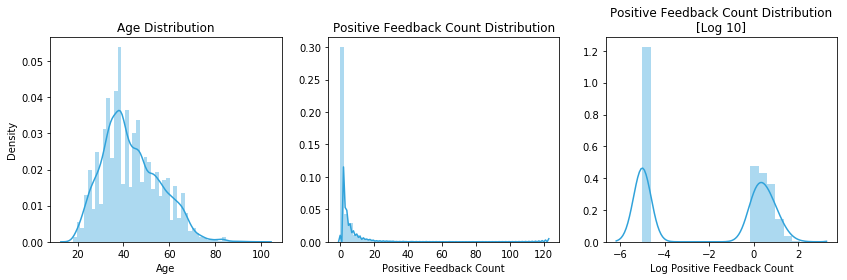

In [8]:
f, ax = plt.subplots(1,3,figsize=(12,4), sharey=False)
sns.distplot(df.Age, ax=ax[0])
ax[0].set_title("Age Distribution")
ax[0].set_ylabel("Density")
sns.distplot(df["Positive Feedback Count"], ax=ax[1])
ax[1].set_title("Positive Feedback Count Distribution")
sns.distplot(np.log10((df["Positive Feedback Count"][df["Positive Feedback Count"].notnull()]+0.00001)), ax=ax[2])
ax[2].set_title("Positive Feedback Count Distribution\n[Log 10]")
ax[2].set_xlabel("Log Positive Feedback Count")

plt.tight_layout()
plt.show()

### **Code Explanation:** <br>
Using Matplotlib, a simple variable frequency barplot is created.

**Code Interpretation:** <br>
The vast majority of reviews were highly positive, with a score of five out of five. This suggests that this retail store is performing fairly well, but comparison to competitors would determine whether it is satisfactory. Competitor reviews may be scraped and analyzed. It is important to note that these reviews are subjective, and some negative reviews may a outcome of a bad day, instead of constructive feedback. In the plot below, the Label plot is the binary classification of 1 = good, and 0= bad.


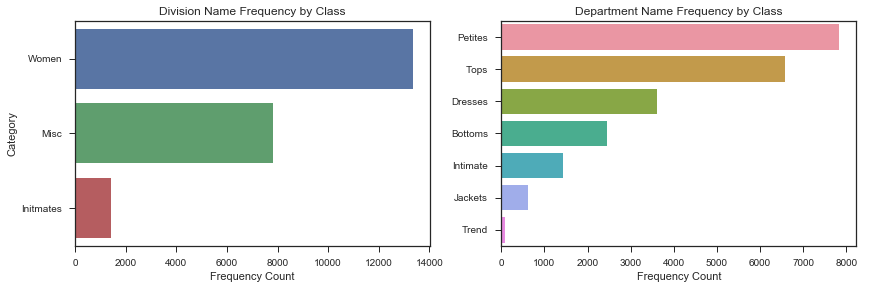

In [142]:
row_plots = ["Division Name","Department Name"]
f, axes = plt.subplots(1,len(row_plots), figsize=(14,4), sharex=False)

for i,x in enumerate(row_plots):
    sns.countplot(y=x, data=df,order=df[x].value_counts().index, ax=axes[i])
    axes[i].set_title("{} Frequency by Class".format(x))
    axes[i].set_xlabel("")
    axes[i].set_xlabel("Frequency Count")
axes[0].set_ylabel("Category")
axes[1].set_ylabel("")
plt.show()

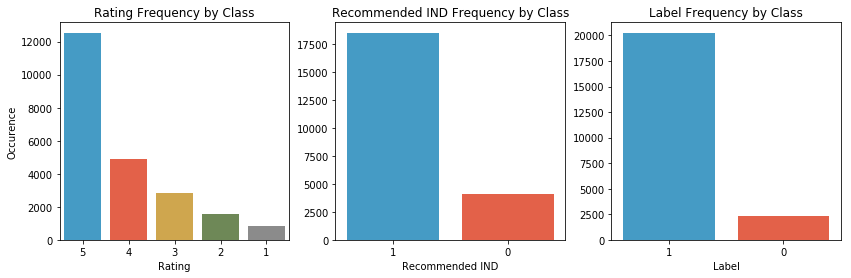

In [10]:
cat_dtypes = [x for x,y,z in unique_count if y < 10 and x not in ["Division Name","Department Name"]]
increment = 0
f, axes = plt.subplots(1,len(cat_dtypes), figsize=(14,4), sharex=False)

for i in range(len(cat_dtypes)):
    sns.countplot(x=cat_dtypes[increment], data=df,order=df[cat_dtypes[increment]].value_counts().index, ax=axes[i])
    axes[i].set_title("{} Frequency by Class".format(cat_dtypes[increment]))
    axes[i].set_ylabel("Occurence")
    axes[i].set_xlabel("{}".format(cat_dtypes[increment]))
    increment += 1
axes[1].set_ylabel("")
axes[2].set_ylabel("")
plt.show()

### 2.2 Multivariate Plotting
### 2.2.1 Finding Redundancy between Categorical Variables

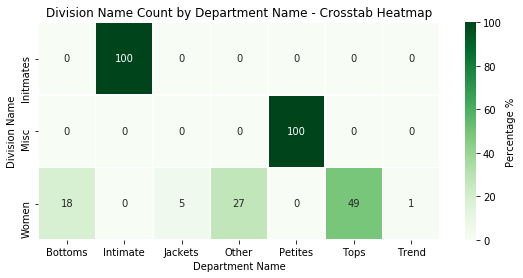

In [11]:
f, ax = plt.subplots(figsize=(9, 4))
s = sns.heatmap(pd.crosstab(df['Division Name'], df["Department Name"], normalize='index').mul(100).round(0),
            annot=True, linewidths=.5, ax=ax,fmt='g', cmap="Greens",
                cbar_kws={'label': 'Percentage %'})
s.set_title('Division Name Count by Department Name - Crosstab Heatmap')
plt.show()

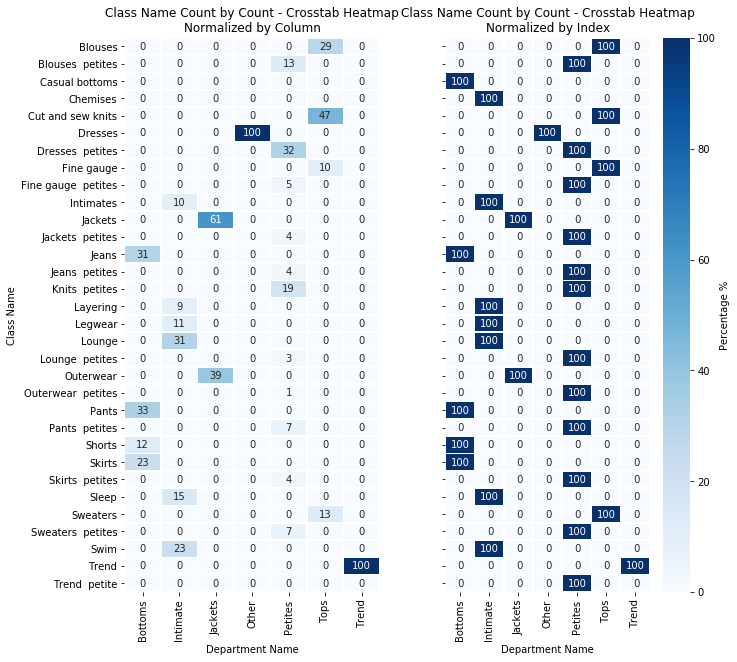

In [12]:
f, ax = plt.subplots(1,2,figsize=(10, 9), sharey=True)
sns.heatmap(pd.crosstab(df['Class Name'], df["Department Name"], normalize = 'columns').mul(100).round(0)
            ,annot=True, fmt="g", linewidths=.5, ax=ax[0],cbar=False,cmap="Blues")
ax[0].set_title('Class Name Count by Count - Crosstab Heatmap\nNormalized by Column')
ax[1] = sns.heatmap(pd.crosstab(df['Class Name'], df["Department Name"], normalize = 'index').mul(100)
            ,annot=True, fmt="2g", linewidths=.5, ax=ax[1],cmap="Blues",
                cbar_kws={'label': 'Percentage %'})
ax[1].set_title('Class Name Count by Count - Crosstab Heatmap\nNormalized by Index')
ax[1].set_ylabel('')
plt.tight_layout(pad=0)

This heatmap above exposes the redundant nature of the "Division Name" variable. Furthermore, it indicates that "Petite" is a unecessary category within "Class Name" since it is already described in the "Department Name" variable as "Petites".

It should also be noted that "Department Name's" Other category only applies to dresses, so it should be renamed as such.

### Fixing the Redundancy

In [149]:
# Replace Other with Dress
df["Department Name"].replace({'Other':'Dresses'}, inplace=True)

# Petites Category
# df["Petites"] = 0
# df["Petites"][df["Department Name"]=="Petites"] = 1 

# Regular Expression to remove "Petites" specification in "Class Name"
class_length_before = len(set(df["Class Name"]))
df["Class Name"]= df["Class Name"].str.replace(
    r"(petites)|(petite)", '').str.strip().str.lower().str.capitalize()
class_length_after = len(set(df["Class Name"]))
                         
print("Class Name Category Count:\nBefore: {}\nAfter: {}\nDifference: {}".format(
    class_length_before, class_length_after,class_length_before-class_length_after))

Class Name Category Count:
Before: 22
After: 22
Difference: 0


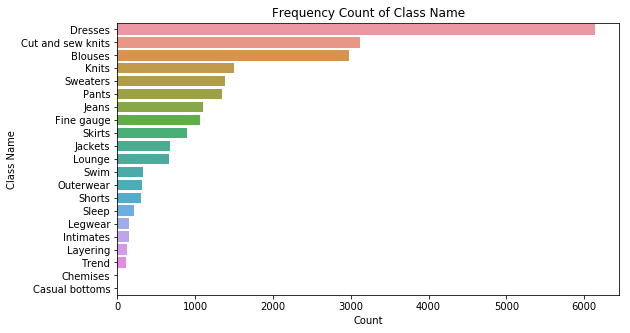

In [14]:
plt.subplots(figsize=(9,5))
sns.countplot(y="Class Name", data=df,order=df["Class Name"].value_counts().index)
plt.title("Frequency Count of Class Name")
plt.xlabel("Count")
plt.show()

### 2.2.2 Plotting Continuous Variables by Category

Here I want to look at the behavior of the continous variables when sliced by various categorical varibles.

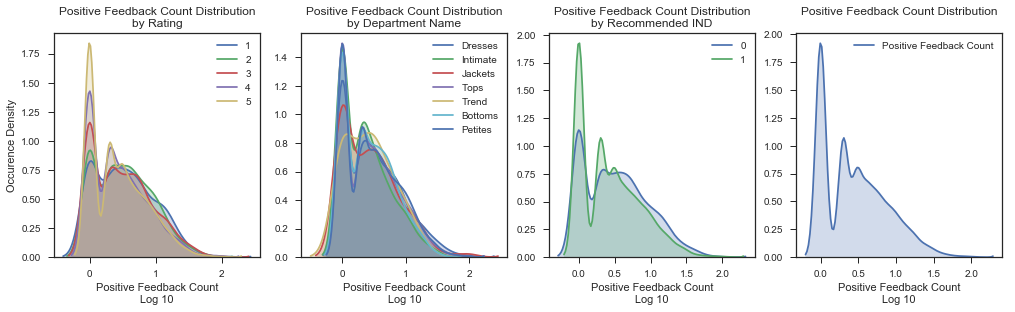

In [207]:
f, axes = plt.subplots(1,4, figsize=(17,4), sharex=False)
xvar = 'Positive Feedback Count'
plotdf = np.log10(df['Positive Feedback Count'])
for i,y in enumerate(["Rating","Department Name","Recommended IND"]):
    for x in set(df[y][df[y].notnull()]):
        sns.kdeplot(plotdf[df[y]==x], label=x, shade=True, ax=axes[i])
    axes[i].set_xlabel("{}\nLog 10".format(xvar))
    axes[i].set_label('Occurence Density')
    axes[i].set_title('{} Distribution\nby {}'.format(xvar, y))

axes[0].set_ylabel('Occurence Density')

sns.kdeplot(plotdf,shade=True,ax=axes[3])
axes[3].set_xlabel("{}\nLog 10".format(xvar))
axes[3].set_title('{} Distribution\n'.format(xvar))
plt.show()

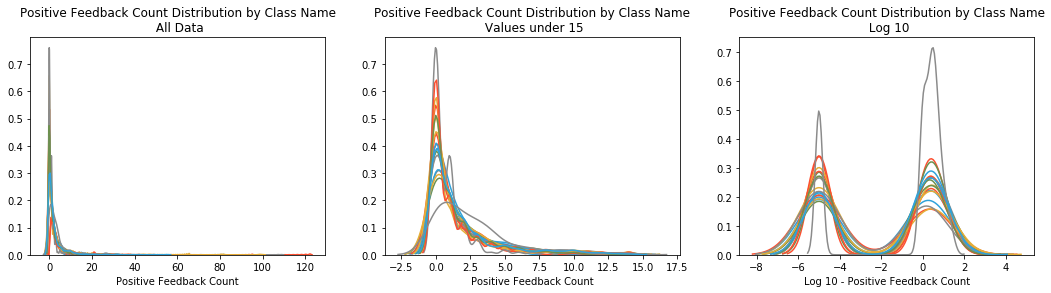

In [16]:
f, axes = plt.subplots(1,3, figsize=(18,4), sharex=False)
for x in set(df["Class Name"][df["Class Name"].notnull()]):
    sns.kdeplot(df['Positive Feedback Count'][df["Class Name"]==x]
                ,label=x, shade=False, ax=axes[0])
    
axes[0].legend_.remove()
axes[0].set_xlabel('{}'.format(xvar))
axes[0].set_title('{} Distribution by {}\n All Data'.format(xvar, "Class Name"))

min_value = 15
for x in set(df["Class Name"][df["Class Name"].notnull()]):
    sns.kdeplot(df['Positive Feedback Count'][(df["Class Name"]==x) &
                                              (df["Positive Feedback Count"] < min_value)]
                ,label=x, shade=False, ax=axes[1])
    
axes[1].legend_.remove()
axes[1].set_xlabel('{}'.format(xvar))
axes[1].set_title('{} Distribution by {}\n Values under {}'.format(xvar, "Class Name", min_value))

for x in set(df["Class Name"][df["Class Name"].notnull()]):
    sns.kdeplot(np.log10(df['Positive Feedback Count']+0.00001)[df["Class Name"]==x]
                ,label=x, shade=False, ax=axes[2])
    
axes[2].legend_.remove()
axes[2].set_xlabel('Log 10 - {}'.format(xvar))
axes[2].set_title('{} Distribution by {}\nAll Data in Log10'.format(xvar, "Class Name"))
plt.show()

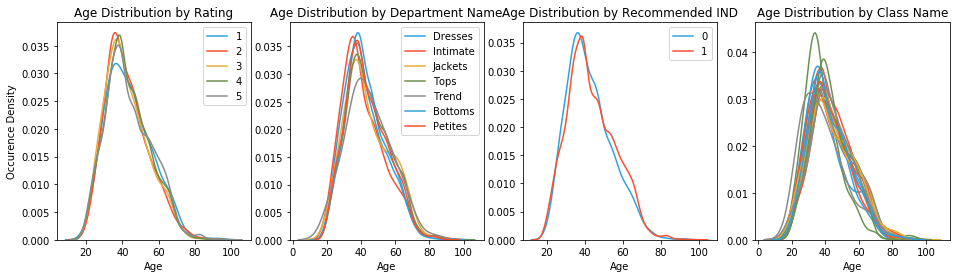

In [17]:
f, axes = plt.subplots(1,4, figsize=(16,4), sharex=False)
xvar = "Age"
plotdf = df["Age"]
for i,y in enumerate(["Rating","Department Name","Recommended IND"]):
    for x in set(df[y][df[y].notnull()]):
        sns.kdeplot(plotdf[df[y]==x], label=x, shade=False, ax=axes[i])
    axes[i].set_xlabel("{}".format(xvar))
    axes[i].set_label('Occurence Density')
    axes[i].set_title('{} Distribution by {}'.format(xvar, y))

for x in set(df["Class Name"][df["Class Name"].notnull()]):
    sns.kdeplot(plotdf[df["Class Name"]==x], label=x, shade=False, ax=axes[3])

axes[3].legend_.remove()
axes[3].set_xlabel('{}'.format(xvar))
axes[0].set_ylabel('Occurence Density')
axes[3].set_title('{} Distribution by {}'.format(xvar, "Class Name"))
plt.show()

### **Code Explanation:** <br>


### **Code Interpretation:** <br>
My a priori expectation was that the biggest group of reviewing customers would be young, tech savvy women between the age of 18 and 34. However, this plot would say otherwise, since it appears that not only is the 34 to 50 year old age most engage in reviewing products, they also appear to be the most positive reviewers, since they proportionately give higher more reviews of 5. Before making insight about these point, it would be wise to gather further data on the age distribution of shoppers. Nevertheless, this trend suggest that the core market segment for this clothing brand is women between 34 and 50.

### 2.2.3 Continous on Continous Analysis

Time for some scatter plots. with [Seaborn Joint Plot](https://tryolabs.com/blog/2017/03/16/pandas-seaborn-a-guide-to-handle-visualize-data-elegantly/).

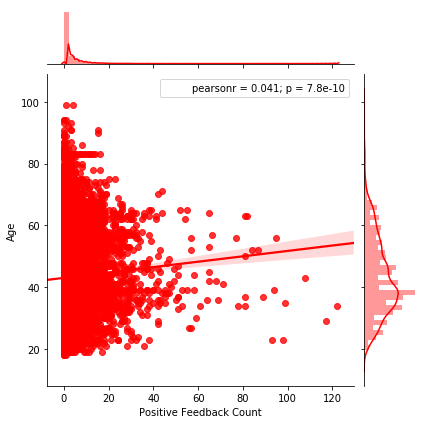

In [18]:
sns.jointplot(x= df["Positive Feedback Count"], y=df["Age"], kind='reg', color='r')
plt.show()

There appears to be a slight correlation between age and positive feedback count received. It would be interesting to focus on the textual anatomy of high positive feedback reviews.

### 2.2.4 Normalized Plotting

Since many variables are severely unbalanced, I employ normalization to see if the proportion is consistent between categorical classes. 

[Normalization in Seaborn - Stackoverflow](https://stackoverflow.com/questions/34615854/seaborn-countplot-with-normalized-y-axis-per-group)

In [19]:
def norm_barplot(x,y,hue, data, ax=None, order= None):
    """
    Normalize the data using pandas functions, then plot using Seaborn.
    Function arguments are and extention of Seaborns'.
    """
    sns.barplot(x= x, y=y, hue=hue, ax=ax, order=order,
    data=(data[[x, hue]]
     .reset_index(drop=True)
     .groupby([x])[hue]
     .value_counts(normalize=True)
     .rename('Percentage').mul(100)
     .reset_index()
     .sort_values(hue)))
    plt.title("Percentage Frequency of {} by {}".format(hue,x))
    plt.ylabel("Percentage %")

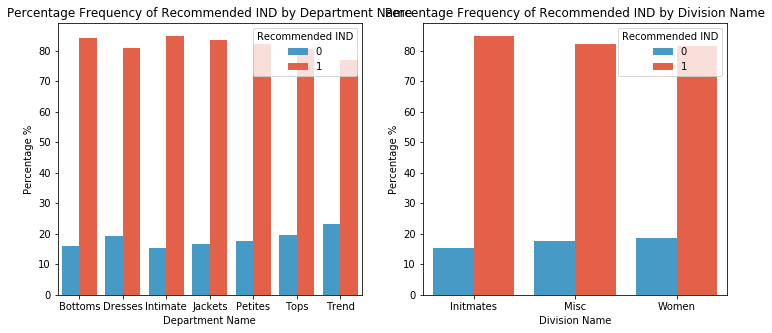

In [20]:
huevar = "Recommended IND"
f, axes = plt.subplots(1,2,figsize=(12,5))
norm_barplot(x="Department Name",y="Percentage", hue=huevar,data=df, ax=axes[0])
axes[0].set_title("Percentage Frequency of {} by Department Name".format(huevar))
axes[0].set_ylabel("Percentage %")
norm_barplot(x="Division Name",y="Percentage", hue=huevar,data=df, ax=axes[1])

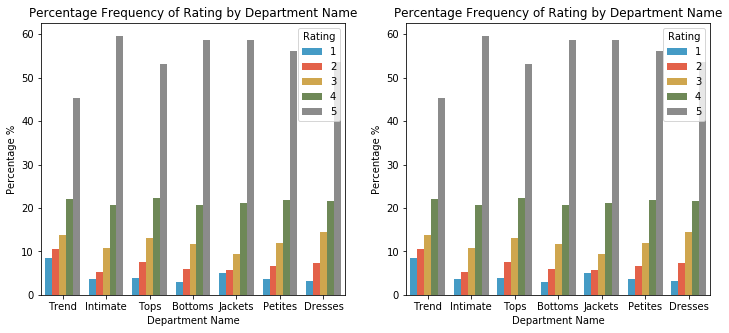

In [21]:
xvar = "Department Name"
huevar = "Rating"
f, axes = plt.subplots(1,2,figsize=(12,5))
norm_barplot(x=xvar,y="Percentage", hue=huevar,data=df, ax=axes[0])
axes[0].set_title("Percentage Frequency of {} by {}".format(huevar, xvar))
axes[0].set_ylabel("Percentage %")
norm_barplot(x=xvar,y="Percentage", hue="Rating",data=df, ax=axes[1])

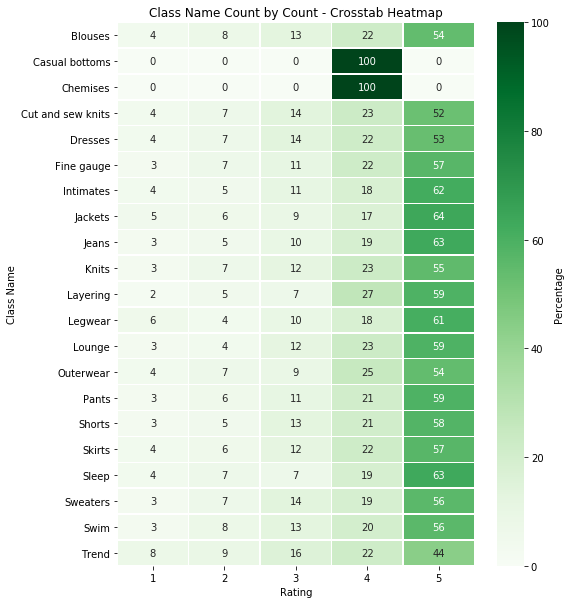

In [22]:
f, ax = plt.subplots(figsize=(8, 10))
# MANUAL NORMALIZE with Applied Lambda on Pandas DataFrame
# ctab = pd.crosstab(df['Class Name'], df["Rating"]).apply(lambda r: r/r.sum(), axis=1).mul(100)
ctab = pd.crosstab(df['Class Name'], df["Rating"], normalize='index').mul(100).round(0)
s = sns.heatmap(ctab,annot=True, linewidths=.5, ax=ax,fmt="g", cmap="Greens",
                cbar_kws={'label': 'Percentage'})
s.set_title('Class Name Count by Count - Crosstab Heatmap')
plt.show()

REWORK THIS

### **Code Explanation:** <br>
Once again using the seaborn package, the type of review (positive 1, negative 0) is explored in terms of the class of clothing. Since this is once again a frequency plot, only the x-axis variable “LABEL” is specified. The hue argument is what assigns separate bars and colors to each class type, and the kind argument specifies that the Label variable should be counted by frequency on the y-axis.

### **Code Interpretation:** <br>
Exploring the class variable suggests that the most popular clothing types are: Petite and Anthro, Dresses, Blouses, and Cut and Sew Knits. The distribution of reviews is fairly constant, suggesting that there are not negative nor positive outliers. This statement has been further verified by taking the mean of the label by class group. The results show that no class falls above .80, and the majority rest at .90. Casual bottoms and Chemises scored the highest in this criteria with a 100% positive review rate, however upon investigation this is because only 4 reviews were made in these categories.


In [23]:
#df.pivot_table(df.Rating.astype(int), index='Class Name', columns=['Department Name'])

In [24]:
# sns.factorplot(x="Department Name", y="Age", hue="smoker"#,col="day",
#                data=df, kind="box", size=4, aspect=.5);

## 2.  PreProcessing <a id="PreProcessing"></a>

### 2.1 Text Processing

In [25]:
pd.set_option('max_colwidth', 500)
df[["Title","Review Text", "Rating"]].sample(7)

,,Title,Review Text,Rating
Sterling External Alias,IDD,,,
4112370000000,100001000000000,NaN,Love this top.!!! This is a very comfortable everyday top worn primarily with jeans. Please make it in more colors. I think it should be less expensive.,4
4130340000000,100001000000000,Divine and comfortable,"First, I've been in love with this dress for months. When it went on sale I absolutely HAD to have it! I'm 5'4"" and 150 pounds and typically wear large stuff from anthro but after reading other reviews I decided to get the medium. It's more generous than I expected and wonder if I could've even gone with a small. I might try a belt. Either way I'm very very happy with the dress. The sleeves are not too long - and I didn't get the petite because I wanted the length in the skirt. The lining ma...",5
4130200000000,100031000000000,NaN,"This dress has rich color, excellent quality fabric and wonderful style. You can wear it now for fall with boots and jean jacket or in the summer for a great sun dress.",5
4120200000000,100001000000000,Wish it was like the picture!,"I anticipated receiving this skirt as I love a longer pencil skirt and this looks beautiful. I opened it, tried it on, sent it back...It is well made but has too many negatives. First, it is VERY thick. I ordered size 6 (5'2"", 140 lbs.). The size was good, but it is so thick that it adds lots of extra fluff around the waist and abdomen. It is also very stretchy and fits in an unflattering way. Finally, and most importantly, it has a back and front vent and both are vented all the way up to t...",2
4112220000000,100000000000000,Comfy and Pretty,"This top is a great addition to my summer wardrobe. I love it because it does not cling to my body, and in a hot humid summer, I want things that FLOW. This is super cute and flattering. The lace in the back is soft, and not too revealing.",5
4112280000000,100041000000000,Lovely,"Cute top, perfect by itself or for layering. I sensed it would run large, so I ordered an xxs, 115 lbs, 5'2"".",5
37670148,100035000000000,Perfect!,This is my first Pure+Good piece. I am not disappointed. I am 125# and a 34C....ordered the small. Fits like a dream. Love the moss color. Nice long sleeves (I will am picky about sleeves). Comfortable fabric. The detail at the cuff is lovely. I can see this versatile piece taking me through the entire year.,5


Evidently, the text data requires further processing .

In [26]:
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer
#ps = LancasterStemmer()
ps = PorterStemmer()

tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))

def preprocessing(data):
    txt = data.str.lower().str.cat(sep=' ') #1
    words = tokenizer.tokenize(txt) #2
    words = [w for w in words if not w in stop_words] #3
    words = [ps.stem(w) for w in words] #4
    return words

### **Code Explanation:** <br>
This chunk of code creates a function that takes each review and combines them into one seamless text. It then applies lowercase, tokenizer, removes stopwords and punctuation, and finally uses the PorterStemmer.

***

### **Code Interpretation:** <br>
In order to process the dataset’s centerpiece, the review body, I utilized the NLTK package to lowercase, tokenize, and remove stopwords and punctuation. Tokenizing treats each word as its own value, while the other steps gets rid of the noise and irrelevant symbols in the data, standardizing the reviews for analysis. Upon reviewing the performance of text analysis, I decided to implement the Porter Stemmer on the tokens in order to combine words with tense and plurality deviance. I contemplated exploring the use of sequential models, such as Long Short-term memory, which would benefit from stopwords, but unfortunately I could only find predictive applications of it, no insight extracting aspects. 

The last piece of data transformation conducted was to bin the continuous variable age into a categorical variable: age category.

### 2.2 Helper/Utility Functions <a id="Helper/Utility Functions"></a>

In [27]:
# # Matplotlib Font Calibration
# def default_font():
#     plt.rc('axes', titlesize=20) # Axes Title Size
#     plt.rc('axes', labelsize=18) # Plot Title Size
#     font = {'family' : 'normal',
#             'weight' : 'normal',
#             'size'   : 15}
#     plt.rc('font', **font) # Label Font

***

## 4. Sentiment Analysis <a id="Sentiment Analysis"></a>

My first attempt at understanding the customer reviews is to see how the textual sentiment relates to the rating scores. With this method, it will be possible to distinguish outright positive and negative comments from the contructive variant.

I will also explore the interaction between sentiment score:
- Raiting
- Recommended
- Positive Feedback Count

In [28]:
# Pre-Processing
SIA = SentimentIntensityAnalyzer()
df["Review Text"]= df["Review Text"].astype(str)

# Applying Model, Variable Creation
df['Polarity Score']=df["Review Text"].apply(lambda x:SIA.polarity_scores(x)['compound'])
df['Neutral Score']=df["Review Text"].apply(lambda x:SIA.polarity_scores(x)['neu'])
df['Negative Score']=df["Review Text"].apply(lambda x:SIA.polarity_scores(x)['neg'])
df['Positive Score']=df["Review Text"].apply(lambda x:SIA.polarity_scores(x)['pos'])

# Converting 0 to 1 Decimal Score to a Categorical Variable
df['Sentiment']=''
df.loc[df['Polarity Score']>0,'Sentiment']='Positive'
df.loc[df['Polarity Score']==0,'Sentiment']='Neutral'
df.loc[df['Polarity Score']<0,'Sentiment']='Negative'

#### **Code Explanation:** <br>
*Pre-processing* chunk loads the NLTK Sentiment Intensity Analyzer module, selects desired variables, and finally applies lowercasing to the column of reviews in the dataframe. The second paragraph of code *Applying Model and Variable Creation* classifies each review in the dataset on three dimensions: Positive, Neutral, and Negative. These results are stored in three respective columns. The overall sentiment is then determined and stored in the Sentiment column.

- Neutral/Negative/Postive Score: Indicates the potency of these classes between 0 and 1. Onl
- Polarity Score: Measures the difference between the Positive/Neutral/Negative values, where a positive numbers closer to 1 indicates overwhelming positivity, and a negative number closer to -1 indicates overwhelming negativity.

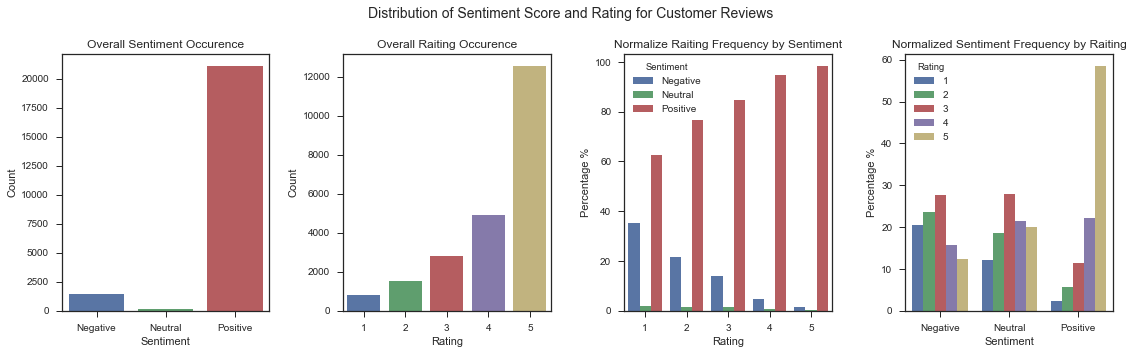

In [213]:
f, axes = plt.subplots(1,4, figsize=[16,5])
sns.countplot(x="Sentiment", data=df, ax=axes[0], order=["Negative","Neutral","Positive"])
axes[0].set_xlabel("Sentiment")
axes[0].set_ylabel("Count")
axes[0].set_title("Overall Sentiment Occurence")

sns.countplot(x="Rating", data=df, ax=axes[1])
axes[1].set_xlabel("Rating")
axes[1].set_ylabel("Count")
axes[1].set_title("Overall Raiting Occurence")

norm_barplot(x="Rating",y="Percentage",hue="Sentiment",data=df, ax=axes[2])
#sns.countplot(x="Rating", hue="Sentiment", data=df, ax=axes[2])
axes[2].set_xlabel("Rating")
axes[2].set_ylabel("Percentage %")
axes[2].set_title("Normalize Raiting Frequency by Sentiment")

norm_barplot(x="Sentiment",y="Percentage",hue="Rating",data=df, ax=axes[3])
axes[3].set_ylabel("Occurence Frequency")
axes[3].set_title("Normalized Sentiment Frequency by Raiting")
axes[3].set_xlabel("Sentiment")
axes[3].set_ylabel("Percentage %")

f.suptitle("Distribution of Sentiment Score and Rating for Customer Reviews", fontsize=14)
f.tight_layout()
f.subplots_adjust(top=0.85)
plt.show()

#### **Interpretation:** <br>
The last chunk, Visualization, plots the frequency of sentiments in a bar plot using matplotlib.

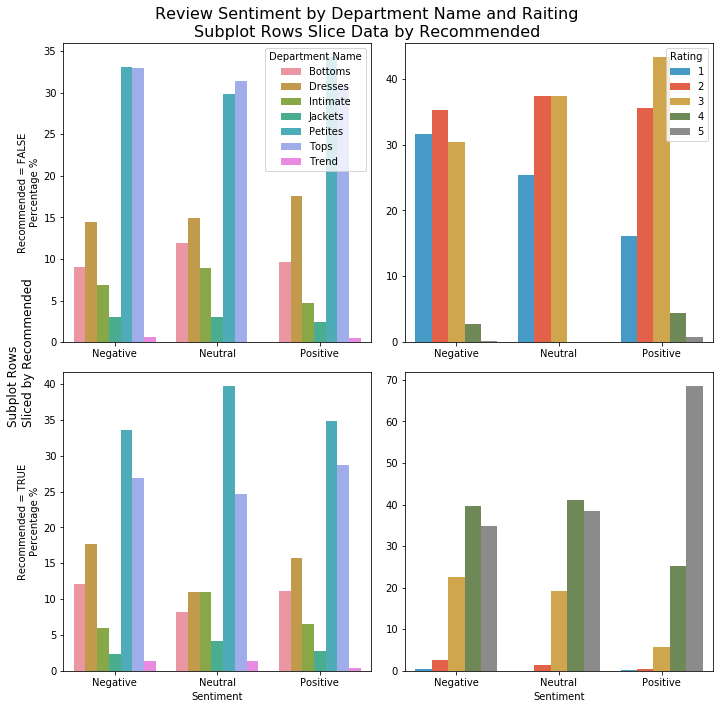

In [30]:
# Tweakable Variables (Note to Change Order Arguement if Xvar is changed)
xvar = "Sentiment"
huevar = "Department Name"
rowvar = "Recommended IND"

# Plot
f, axes = plt.subplots(2,2,figsize=(10,10), sharex=False,sharey=False)
for i,x in enumerate(set(df[rowvar][df[rowvar].notnull()])):
    norm_barplot(x=xvar,y="Percentage", hue=huevar,data=df[df[rowvar] == x],
                 ax=axes[i,0], order=["Negative","Neutral","Positive"])
    norm_barplot(x=xvar,y="Percentage", hue="Rating",data=df[df[rowvar] == x],
                 ax=axes[i,1], order=["Negative","Neutral","Positive"])

# Plot Aesthetics
axes[1,0].legend_.remove()
axes[1,1].legend_.remove()
axes[0,1].set_ylabel("")
axes[1,1].set_ylabel("")
axes[0,0].set_xlabel("")
axes[0,1].set_xlabel("")
axes[0,0].set_ylabel("Recommended = FALSE\nPercentage %")
axes[1,0].set_ylabel("Recommended = TRUE\nPercentage %")
axes[1,1].set_title("")

# Common title and ylabel
f.text(0.0, 0.5, 'Subplot Rows\nSliced by Recommended', va='center', rotation='vertical', fontsize=12)
f.suptitle("Review Sentiment by Department Name and Raiting\nSubplot Rows Slice Data by Recommended", fontsize=16)
f.tight_layout()
f.subplots_adjust(top=0.93)
plt.show()

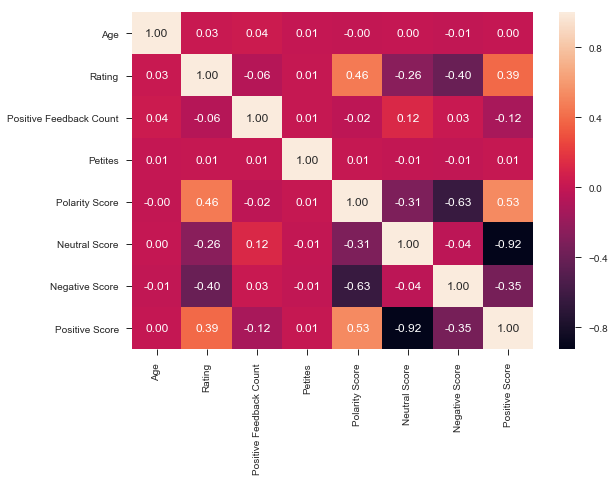

In [227]:
df.Rating = df.Rating.astype(int)
# Plot Correlation Matrix
f, ax = plt.subplots(figsize=[9,6])
ax = sns.heatmap(df.corr(), annot=True, fmt=".2f")

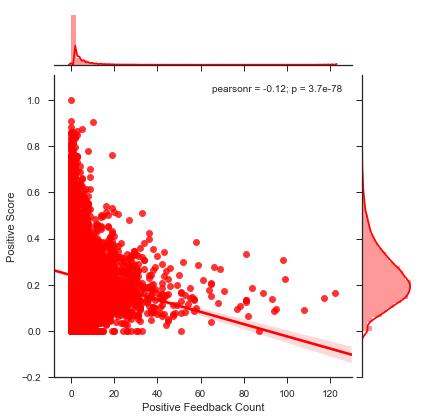

In [238]:
# Sentiment Positivity Score by Positive Feedback Count
ax = sns.jointplot(x= df["Positive Feedback Count"], y=df["Positive Score"], kind='reg', color='r')
plt.show()

Interestingly, there appears to be a substantial negative correlation between Positive Feedback Count and Positive Score, which suggests that the most acclaimed reviews on the platform are probably in the form on constructive criticism, rather than outright positivity.

## 6. Word Distribution and Word Cloud <a id="Word Distribution and Word Cloud"></a> <br>
Now that a general understanding of the variables have been laid out, I will begin to analysis the customer reviews. Using the categories good and bad, I created two separate word clouds.

** For this section, I deviated from the book and heavily relied upon the following online resources:** <br>
- [Kaggle Longdoa: Word Cloud in Python](https://www.kaggle.com/longdoan/word-cloud-with-python)
- [Word Cloud Package Forum](https://github.com/amueller/word_cloud/issues/134)
- [Amueller Github](https://amueller.github.io/word_cloud/auto_examples/masked.html)

In [154]:
stopwords = set(STOPWORDS)
size = (20,10)

def cloud(text, title, stopwords=stopwords, size=size):
    """
    Function to plot WordCloud
    Includes: 
    """
    # Setting figure parameters
    mpl.rcParams['figure.figsize']=(10.0,10.0)
    mpl.rcParams['font.size']=12
    mpl.rcParams['savefig.dpi']=100
    mpl.rcParams['figure.subplot.bottom']=.1 
    
    # Processing Text
    # Redundant when combined with my Preprocessing function
    wordcloud = WordCloud(width=1600, height=800,
                          background_color='black',
                          stopwords=stopwords,
                         ).generate(str(text))
    
    # Output Visualization
    fig = plt.figure(figsize=size, facecolor='k')
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(title, fontsize=50,color='y')
    plt.tight_layout(pad=0)
    plt.show()
    
# Frequency Calculation [One-Gram]
def wordfreqviz(text, x):
    word_dist = nltk.FreqDist(text)
    top_N = x
    rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
    matplotlib.style.use('ggplot')
    rslt.plot.bar(rot=0)

def wordfreq(text, x):
    word_dist = nltk.FreqDist(text)
    top_N = x
    rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
    return rslt

#### **Code Explanation:** <br>
This code creates the word cloud visualization function. This function’s mathematical processes are hidden, since it does not explicitly state that it determines the frequency occurrence of each word in relation to the entire dictionary of words. Within the function, the Setting Function Parameter section creates the graphic structure using matplotlib. Then the text is formatted, and the word frequency is determined. Finally, the matplotlib structure is filled with words, where the larger the word size, the higher the word occurrence. 

### Visualize Titles

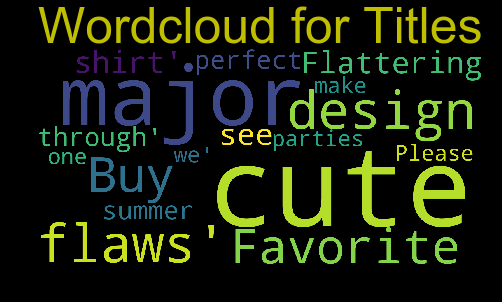

In [170]:
# Cloud
cloud(text= df.Title[df.Title.notnull()].astype(str).values,
      title="Wordcloud for Titles",
      stopwords= new_stop,
      size = (7,4))

### Visualize Reviews

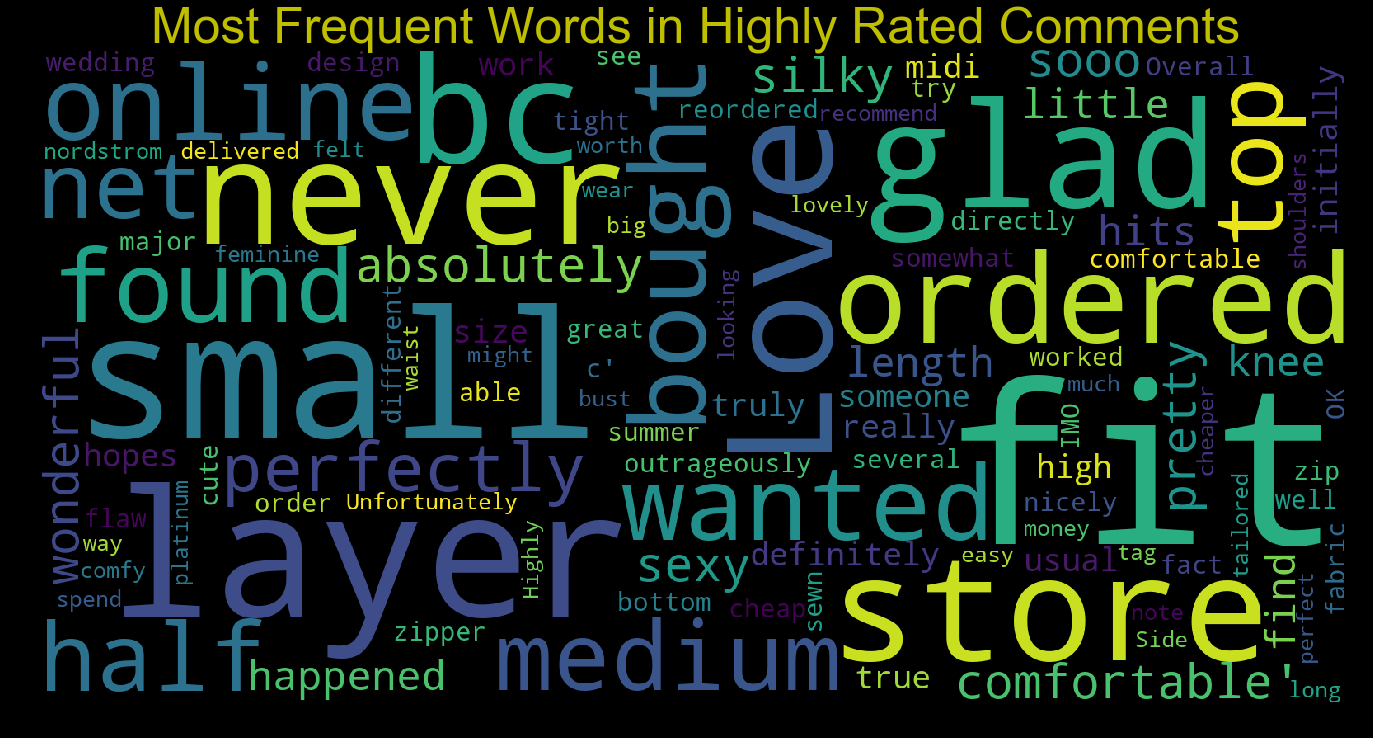

In [124]:
# Highly Raited
title ="Most Frequent Words in Highly Rated Comments"
temp = df['Review Text'][df.Rating.astype(int) >= 3]

# Modify Stopwords to Exclude Class types, suchs as "dress"
new_stop = set(STOPWORDS)
new_stop.update([x.lower() for x in list(df["Class Name"][df["Class Name"].notnull()].unique())]
                + ["dress", "petite"])

# Cloud
cloud(text= temp.values, title=title,stopwords= new_stop)

# Bar Chart
wordfreq(preprocessing(temp),20).plot.bar(rot=45, legend=False,figsize=(15,5), color='g',
                          title= title)
plt.ylabel("Occurence Count")
plt.xlabel("Most Frequent Words")
plt.show()

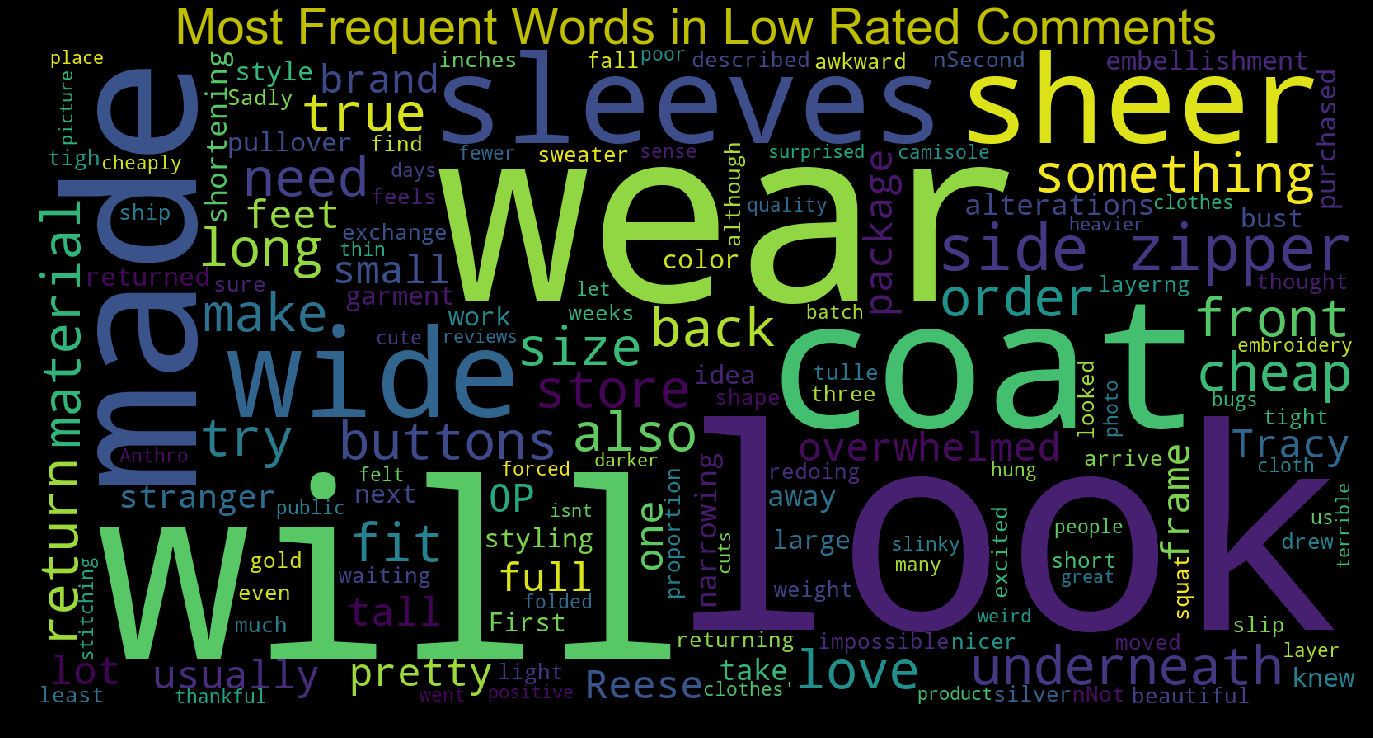

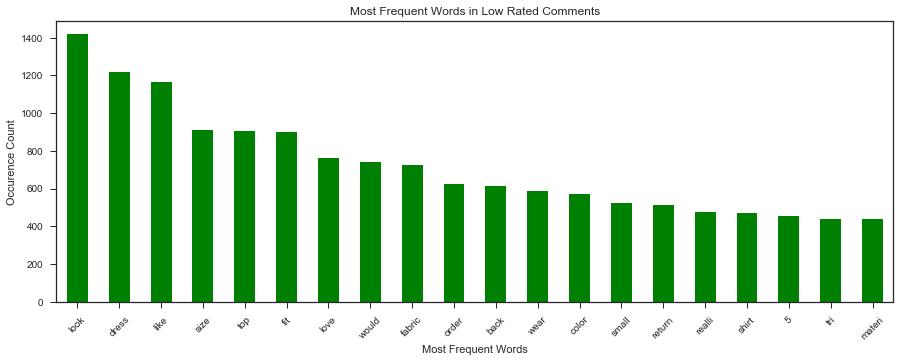

In [126]:
# Low Raited
title ="Most Frequent Words in Low Rated Comments"
temp = df['Review Text'][df.Rating.astype(int) < 3]

# Modify Stopwords to Exclude Class types, suchs as "dress"
new_stop = set(STOPWORDS)
new_stop.update([x.lower() for x in list(df["Class Name"][df["Class Name"].notnull()].unique())]
                + ["dress", "petite", "skirt","shirt"])

# Cloud
cloud(temp.values, title= title, stopwords = new_stop)

#### **Code Interpretation:** <br>
At a first glance the most common words overlap significantly between good and bad reviews. Indeed, the observation that “Dress” and “Top” are the most common words is reflected by the disproportionate number of reviews in the dress category. Looking at the rest of the words, the positive reviews tend to use words such as: Love, Comfortable, Great, Style, Small, Flattering, Wear, True. This offers the first big insight because within the expected positive words, the words “True” stands out, since it suggest consistency between customer expectation of the product and what the product actually delivered. In terms of negative reviews, notable words include: unflattering, big, unfortunately appear. These negative words represent the small proportion of words in the negative reviews. This suggests that either people are expressing their criticism with negative prefixes, such as “Not Pretty”, or people are sticking to constructive criticism only, addressing problems of fit or appearance rather than simply expressing anger.

The central flaw of these word clouds is that they only show the distribution of individual words. This removes the context of the word, as well as disregard negative prefixes. In order to solve this problem I will utilize n-grams, which increases the size of observed values from one word to multiple words, enabling frequency counts to be conducted to word sequences. Although I would have prefered to visualize these findings through the use of Word Clouds, I was unable to program this in, thus leaving me with a simple table.

In the section below, the 15th most frequent 2 and 3 gram sequences are on display for both the good and bad reviews.

### I am curious to see the wordcloud by Specific group.

Perhaps I can seperate this analysis between clouds and ngrams.

1. Department Name
2. Over 20 Positive Review Count
3. Whether it was Recommended IND

In [189]:
department_set = df["Department Name"][df["Department Name"].notnull()].unique()

def cloud_by_category(data, category, subclass):
    """
    Function to create a wordcloud by class and subclass
    Category signifies the column variable
    Subclass refers to the specific value within the categorical variable
    """
    new_stop = set(STOPWORDS)
    new_stop.update([x.lower() for x in list(data["Class Name"][data["Class Name"].notnull()].unique())]
                   + [x.lower() for x in list(data["Department Name"][data["Department Name"].notnull()].unique())]
                   + ["dress", "petite", "jacket","top"])

    # Cloud
    cloud(text= data["Review Text"][data[category]== subclass],
          title="WordCloud for {}".format(subclass),
          stopwords= new_stop,
          size = (10,6))

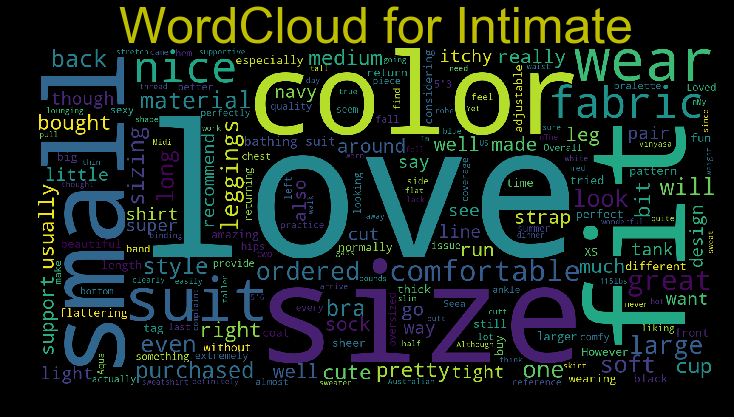

In [190]:
cloud_by_category(df, "Department Name", department_set[0])

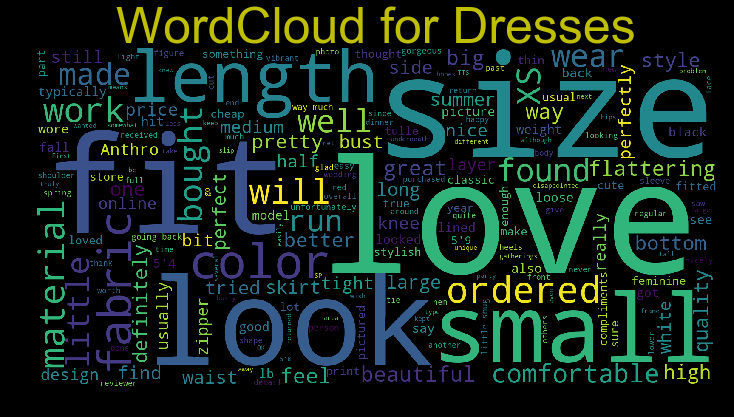

In [191]:
cloud_by_category(df, "Department Name", department_set[1])

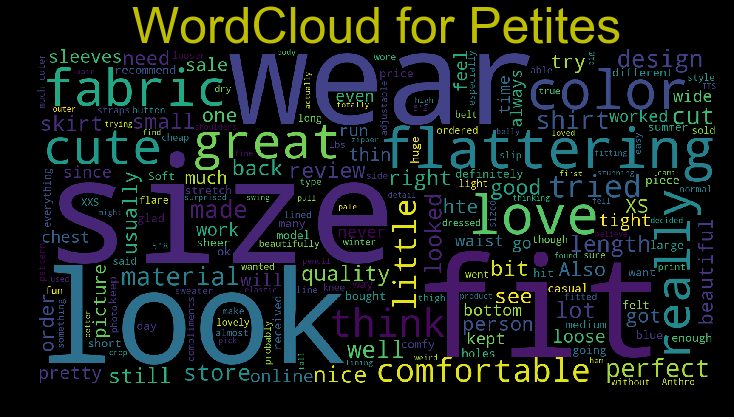

In [192]:
cloud_by_category(df, "Department Name", department_set[2])

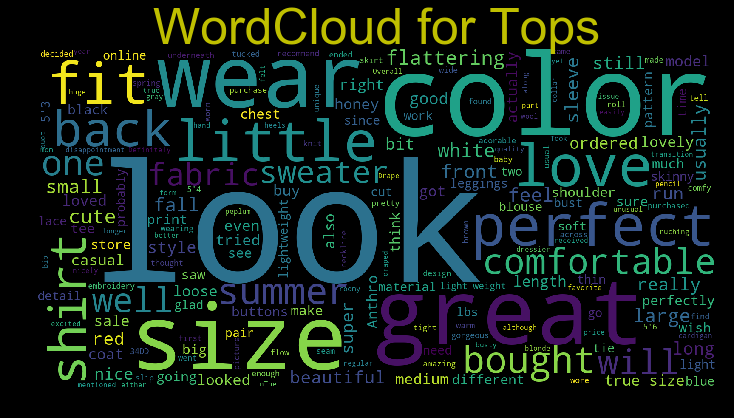

In [193]:
cloud_by_category(df, "Department Name", department_set[3])

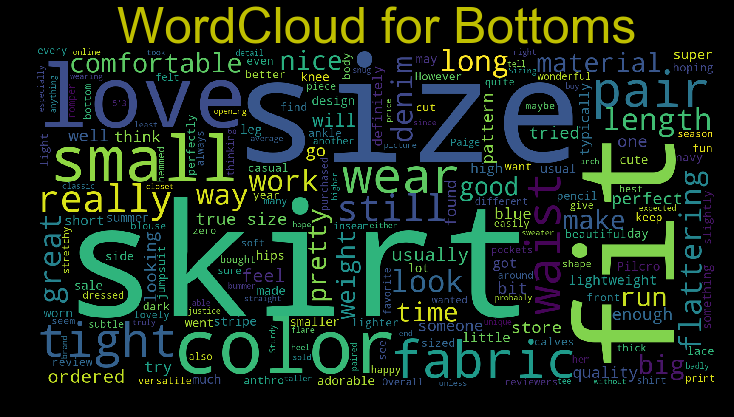

In [194]:
cloud_by_category(df, "Department Name", department_set[4])

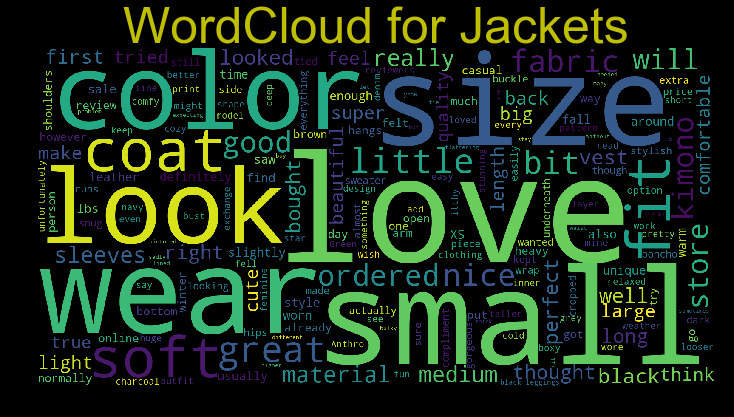

In [196]:
cloud_by_category(df, "Department Name", department_set[5])

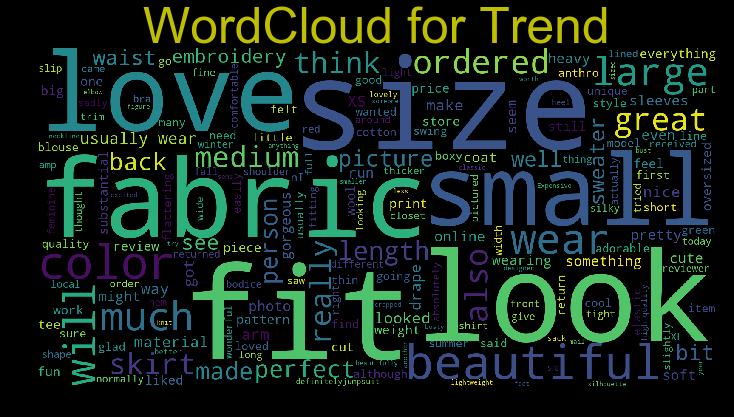

In [197]:
cloud_by_category(df, "Department Name", department_set[6])

In [199]:
"""
for x in set(df["Department Name"][df["Department Name"].notnull()]):
    # Modify Stopwords to Exclude Class types, suchs as "dress"
    new_stop = set(STOPWORDS)
    new_stop.update([x.lower() for x in list(df["Class Name"][df["Class Name"].notnull()].unique())]
                    + ["dress", "petite", "jacket","top"]
                    + [x.lower() for x in list(df["Department Name"][df["Department Name"].notnull()].unique())])

    # Cloud
    cloud(text= df["Review Text"][df["Department Name"]== x],
          title="WordCloud for {}".format(x),
          stopwords= new_stop,
          size = (10,6))
"""

'\nfor x in set(df["Department Name"][df["Department Name"].notnull()]):\n    # Modify Stopwords to Exclude Class types, suchs as "dress"\n    new_stop = set(STOPWORDS)\n    new_stop.update([x.lower() for x in list(df["Class Name"][df["Class Name"].notnull()].unique())]\n                    + ["dress", "petite", "jacket","top"]\n                    + [x.lower() for x in list(df["Department Name"][df["Department Name"].notnull()].unique())])\n\n    # Cloud\n    cloud(text= df["Review Text"][df["Department Name"]== x],\n          title="WordCloud for {}".format(x),\n          stopwords= new_stop,\n          size = (10,6))\n'

## N Grams
Expand on this section by making new variables out of interesting words.

In [200]:
## Helper Functions
from nltk.util import ngrams
from collections import Counter
def get_ngrams(text, n):
    n_grams = ngrams((text), n)
    return [ ' '.join(grams) for grams in n_grams]

def gramfreq(text,n,num):
    # Extracting bigrams
    result = get_ngrams(text,n)
    # Counting bigrams
    result_count = Counter(result)
    # Converting to the result to a data frame
    df = pd.DataFrame.from_dict(result_count, orient='index')
    df = df.rename(columns={'index':'words', 0:'frequency'}) # Renaming index column name
    return df.sort_values(["frequency"],ascending=[0])[:num]

def gram_table(data, gram, length):
    out = pd.DataFrame(index=None)
    for i in gram:
        table = pd.DataFrame(gramfreq(preprocessing(data),i,length).reset_index())
        table.columns = ["{}-Gram".format(i),"Occurence"]
        out = pd.concat([out, table], axis=1)
    return out

In [204]:
gram_table(data= df['Review Text'][df.Rating.astype(int) >= 3], gram=[1,2,3,4,5], length=30)

,1-Gram,Occurence,2-Gram,Occurence,3-Gram,Occurence,4-Gram,Occurence,5-Gram,Occurence
0,dress,10969,true size,1299,fit true size,478,compliment everi time wear,50,34b 26 waist 36 hip,27
1,love,10634,fit perfectli,1064,run true size,198,look great skinni jean,32,get compliment everi time wear,25
2,fit,10613,look great,952,receiv mani compliment,172,26 waist 36 hip,32,5 2 current 33 25,17
3,size,9809,love dress,861,love love love,142,34b 26 waist 36,28,115 lb 30 dd 26,15
4,look,7935,look like,824,small fit perfectli,141,get compliment everi time,27,lb 30 dd 26 5,13
5,wear,7487,5 4,669,fit like glove,135,5 4 120 lb,26,115 lb 30dd 26 5,13
6,top,7468,usual wear,630,usual wear size,117,dress fit true size,25,2 current 33 25 37,13
7,color,6727,love top,628,order usual size,102,love love love dress,22,5 1 5 115 lb,12
8,like,6711,fit well,622,look great jean,89,fit true size 5,22,5 2 34b 26 waist,12
9,great,5849,usual size,594,run littl big,89,115 lb 30 dd,22,lb 30dd 26 5 waist,12


In [205]:
gram_table(data= df['Review Text'][df.Rating.astype(int) < 3], gram=[1,2,3,4,5], length=30)

,1-Gram,Occurence,2-Gram,Occurence,3-Gram,Occurence,4-Gram,Occurence,5-Gram,Occurence
0,look,1419,look like,330,realli want love,40,look like matern top,9,refer 5 7 130 lb,2
1,dress,1218,go back,178,realli want like,29,realli want like top,8,true size match model photo,2
2,like,1164,want love,126,want love dress,24,realli want love dress,8,order review back pair went,2
3,size,912,realli want,86,fit true size,22,5 4 120 lb,6,review back pair went shame,2
4,top,907,made look,79,look noth like,20,realli want like dress,6,back pair went shame color,2
5,fit,899,felt like,68,make look like,20,look like matern dress,5,pair went shame color pictur,2
6,love,761,5 4,66,look like wear,20,return realli want love,5,went shame color pictur want,2
7,would,743,usual wear,66,sadli go back,19,look noth like model,5,shame color pictur want made,2
8,fabric,726,love dress,64,look like matern,19,look anyth like pictur,4,color pictur want made actual,2
9,order,625,make look,61,made look like,19,realli want love shirt,4,pictur want made actual jean,2


## Intelligible Supervised Learning

In [ ]:
df['tokenized'] = df["Review Text"].astype(str).str.lower() # Turn into lower case text
df['tokenized'] = df.apply(lambda row: tokenizer.tokenize(row['tokenized']), axis=1) # Apply tokenize to each row
df['tokenized'] = df['tokenized'].apply(lambda x: [w for w in x if not w in stop_words]) # Remove stopwords from each row
df['tokenized'] = df['tokenized'].apply(lambda x: [ps.stem(w) for w in x]) # Apply stemming to each row
all_words = nltk.FreqDist(preprocessing(df['Review Text'])) # Calculate word occurence from whole block of text

vocab_count = 300
word_features= list(all_words.keys())[:vocab_count] # 5000 most recurring unique words
print("Number of words columns (One Hot Encoding): {}".format(len(all_words)))

In [ ]:
labtext= list(zip(data.tokenized, (data.LABEL))) 
# Tuple each review with its label (1= greater/equal to 3, 0= under 3)

In [ ]:
# Function to create model features
# for each review, records which uniqeue words out of the whole text body are present
def find_features(document):
    words = set(document)
    features = {}
    for w in word_features:
        features[w] = (w in words)

    return features

In [ ]:
# Apply function to data
featuresets = [(find_features(text), LABEL) for (text, LABEL) in labtext]
len(featuresets)

In [ ]:
training_set = featuresets[:15000]
testing_set = featuresets[15000:]

## Naive Bayes

In [ ]:
%%time
%%memit
classifier = nltk.NaiveBayesClassifier.train(training_set) # Very scalable algorithm
# Posterior = prior_occurence * likelihood / evidence

In [ ]:
print("Classifier accuracy percent:",(nltk.classify.accuracy(classifier, testing_set))*100)
print(classifier.show_most_informative_features(40))

## Word2Vec

In [ ]:
#import gensim
from gensim.models import word2vec
import os
os.chdir(r"D:\My Computer\DATA\Retail")
os.listdir()

In [ ]:
# Load Google's pre-trained Word2Vec model.
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [ ]:
data.head()

In [ ]:
w2vec = word2vec.Word2Vec(data["tokenized"], min_count=5, size=200)

In [ ]:
w2vec.most_similar(["versatil"],topn=10)

In [ ]:
w2vec.most_similar(["potato"],topn=10)

In [ ]:
w2vec.most_similar(["worst"],topn=10)

In [ ]:
w2vec.most_similar(["rag"],topn=10)

In [ ]:
w2vec.most_similar(["compliment"],topn=10)

In [ ]:
w2vec.most_similar(["love"],topn=10)

In [ ]:
w2vec.most_similar(["shame"],topn=10)

In [ ]:
w2vec.most_similar(["dear"],topn=10)